In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
from torchsummary import summary
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### Dataset and Dataloader

In [2]:
class Text(Dataset):
    def __init__(self, path, img_transform = None, blur_transform = None):
        self.path = path
        self.no_images = len(os.listdir(self.path))//3
        self.img_transform = img_transform
        self.blur_transform = blur_transform
        
    
    def __len__(self):
        return self.no_images
    
    def __getitem__(self, idx):
        
        assert 0<=idx<=self.no_images-1, "Invalid index"
        
        image_prefix = (7-len(str(idx)))*"0" + str(idx)
        blur_img_path = os.path.join(self.path, image_prefix + "_blur.png")
        blur_path = os.path.join(self.path, image_prefix + "_psf.png")
        clean_img_path = os.path.join(self.path, image_prefix + "_orig.png")
        
        blur_kernel = Image.open(blur_path)
        blur_img = Image.open(blur_img_path)
        clean_img = Image.open(clean_img_path)
        
                
        if self.img_transform:
            blur_img = self.img_transform(blur_img)
            clean_img = self.img_transform(clean_img)
        if self.blur_transform:
            blur_kernel = self.blur_transform(blur_kernel)
        
        return blur_kernel, blur_img, clean_img
    

img_transform = Compose([
    Resize((256,256)),
    ToTensor(),
])

blur_transform = Compose([
    Resize((17,17)),
    ToTensor(),
])
text = Text("/notebooks/dataset/text/data/", img_transform, blur_transform)
no_train = int(0.8*len(text))
no_test = len(text)-no_train
train_data, test_data = torch.utils.data.random_split(text, [no_train, no_test])

In [3]:
batch_size = 8

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Model

In [4]:
# taken from https://github.com/SeungjunNah/DeepDeblur-PyTorch/blob/master/src/model/common.py but change default_act to LeakyReLU

def default_act():
    return nn.LeakyReLU(True)

def default_conv(in_channels, out_channels, kernel_size, bias=True, groups=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=(kernel_size // 2), bias=bias, groups=groups)

class ResBlock(nn.Module):
    def __init__(self, n_feats, kernel_size, bias=True, conv=default_conv, norm=False, act=default_act):
        super(ResBlock, self).__init__()
        modules = []
        for i in range(2):
            modules.append(conv(n_feats, n_feats, kernel_size, bias=bias))
            if norm: modules.append(norm(n_feats))
            if act and i == 0: modules.append(act())
        self.body = nn.Sequential(*modules)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

# layer = ResBlock(64, 3, norm = nn.BatchNorm2d).to("cuda")
# summary(layer, (64,8,8))

# taken from https://github.com/yuanjunchai/IKC/blob/master/codes/models/modules/sftmd_arch.py
    
class SFT_Layer(nn.Module):
    def __init__(self, nf=64, para=10):
        super(SFT_Layer, self).__init__()
        self.mul_conv1 = nn.Conv2d(para + nf, 32, kernel_size=3, stride=1, padding=1)
        self.mul_leaky = nn.LeakyReLU(0.2)
        self.mul_conv2 = nn.Conv2d(32, nf, kernel_size=3, stride=1, padding=1)

        self.add_conv1 = nn.Conv2d(para + nf, 32, kernel_size=3, stride=1, padding=1)
        self.add_leaky = nn.LeakyReLU(0.2)
        self.add_conv2 = nn.Conv2d(32, nf, kernel_size=3, stride=1, padding=1)

    def forward(self, feature_maps, para_maps):
        cat_input = torch.cat((feature_maps, para_maps), dim=1)
        mul = torch.sigmoid(self.mul_conv2(self.mul_leaky(self.mul_conv1(cat_input))))
        add = self.add_conv2(self.add_leaky(self.add_conv1(cat_input)))
        return feature_maps * mul + add


# layer = SFT_Layer().to("cuda")
# summary(layer, [(64,8,8), (10, 8, 8)])

In [5]:
# custom U-NET taken from https://amaarora.github.io/2020/09/13/unet.html#u-net

class EncoderBlock(nn.Module):
    def __init__(self,
                 n_res_block=2, 
                 n_feats=64, 
                 kernel_size=3, 
                 norm=nn.BatchNorm2d, 
                 n_kernel=10):
        super(EncoderBlock, self).__init__()
        self.res_blocks = nn.ModuleList([ResBlock(n_feats, kernel_size, norm = nn.BatchNorm2d) for i in range(n_res_block)])
        self.sft_layer = SFT_Layer(n_feats, n_kernel)
    
    def forward(self, img, blur_kernel):
        x = img
        for block in self.res_blocks:
            x = block(x)
        x = self.sft_layer(x, blur_kernel)
        return x

# encoder_block = EncoderBlock().to("cuda")
# summary(encoder_block, [(64,8,8), (10,8,8)])

class Encoder(nn.Module):
    def __init__(self, 
                 n_scales=5, 
                 n_feats=64, 
                 n_kernel=10):
        super(Encoder, self).__init__()
        self.enc_blocks = nn.ModuleList([EncoderBlock(n_feats = n_feats, n_kernel=n_kernel) for i in range(n_scales)])
        self.downsample_layer = nn.Conv2d(n_feats, n_feats, kernel_size=3, stride=2, padding=1)
        self.downsample_kernel_layer = nn.Conv2d(n_kernel, n_kernel, kernel_size=3, stride=2, padding=1)
    
    def forward(self, img, blur_kernel):
        x = img
        y = blur_kernel
        encoder_blocks = []
        blur_blocks = []
        for block in self.enc_blocks:
            x = block(x, y)
            encoder_blocks.append(x)
            blur_blocks.append(y)
            x = self.downsample_layer(x)
            y = self.downsample_kernel_layer(y)
        return encoder_blocks, blur_blocks

# print("-------Test encoder--------")
# encoder = Encoder().to("cuda")
# enc_list, blur_list = encoder(torch.rand(1,64,64,64, device="cuda"), torch.rand(1,10,64,64, device="cuda"))
# for enc in enc_list:
#     print(enc.size())
# print("---blur---")
# for blur in blur_list:
#     print(blur.size())
# print("---------------------------")

    
class DecoderBlock(nn.Module):
    def __init__(self,
                 n_res_block=2, 
                 n_feats=64, 
                 kernel_size=3, 
                 norm=nn.BatchNorm2d, 
                 n_kernel=10):
        super(DecoderBlock, self).__init__()
        self.reduce_channel_conv = nn.Conv2d(n_feats*2, n_feats, kernel_size=1)
        self.res_blocks = nn.ModuleList([ResBlock(n_feats, kernel_size, norm = nn.BatchNorm2d) for i in range(n_res_block)])
        self.sft_layer = SFT_Layer(n_feats, n_kernel)
    
    def forward(self, img, blur_kernel):
        x = self.reduce_channel_conv(img)
        for block in self.res_blocks:
            x = block(x)
        x = self.sft_layer(x, blur_kernel)
        return x
    
# decoder_block = DecoderBlock().to("cuda")
# summary(decoder_block, [(128,8,8), (10,8,8)])
    
class Decoder(nn.Module):
    def __init__(self, 
                 n_scales=4, 
                 n_feats=64):
        super(Decoder, self).__init__()
        self.upsample_layer = nn.ConvTranspose2d(n_feats, n_feats, kernel_size=3, stride=2)
        self.dec_blocks = nn.ModuleList([DecoderBlock(n_feats=n_feats) for i in range(n_scales)]) 
        
    def forward(self, encoder_blocks, blur_blocks):
        x = encoder_blocks.pop()
        y = blur_blocks.pop()
        for block in self.dec_blocks:
            x = self.upsample_layer(x)
            z = encoder_blocks.pop()
            y = blur_blocks.pop()
            x = self.crop(x, z)
            x = torch.cat([x, z], dim=1)
            x = block(x, y)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

# print("-------Test decoder--------")
# decoder = Decoder().to("cuda")
# dec = decoder(enc_list, blur_list)
# print(dec.size())
# print("---------------------------")


class DeblurNet(nn.Module):
    def __init__(self,
                 n_img_channel=3,
                 n_scales=4, 
                 n_feats=64, 
                 n_kernel=10):
        super(DeblurNet, self).__init__()
        self.encoder = Encoder(n_scales=n_scales+1, n_feats=n_feats, n_kernel=n_kernel)
        self.decoder = Decoder(n_scales=n_scales, n_feats=n_feats)
        self.conv_in = nn.Conv2d(n_img_channel, n_feats, kernel_size=7, padding=3)
        self.conv_mean_out = nn.Conv2d(n_feats, n_img_channel, kernel_size=7, padding=3)
        self.conv_var_out = nn.Conv2d(n_feats, n_img_channel, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()
        self.batchnorm = nn.BatchNorm2d(n_img_channel)

    def forward(self, img, blur_kernel):
        x = self.conv_in(img)
        enc_list, blur_list = self.encoder(x, blur_kernel)
        x = self.decoder(enc_list, blur_list)
        mean = self.conv_mean_out(x)
        mean = self.sigmoid(mean)
        var = self.conv_var_out(x)
        var = self.sigmoid(var)
        return mean, var

# print("------Test DeblurNet-------")
# deblur = DeblurNet().to("cuda")
# mu, var = deblur(torch.rand(2,3,256,256,device="cuda"), torch.rand(2,10,256,256,device="cuda"))
# print(mu.size())
# print(var.size())

In [6]:
# KernelNet network 

class KernelNet(nn.Module):
    def __init__(self, blur_kernek_size, pretrain_resnet="resnet18"):
        super(KernelNet, self).__init__()
        self.blur_kernek_size = blur_kernek_size
        if pretrain_resnet == "resnet18":
            self.pretrain = models.resnet18(pretrained=True)
        elif pretrain_resnet == "resnet34":
            self.pretrain = models.resnet34(pretrained=False)
        for param in self.pretrain.parameters():
            param.requires_grad = False
        num_ftrs = self.pretrain.fc.out_features
        self.linear = nn.Linear(num_ftrs, self.blur_kernek_size**2)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        res = self.pretrain(x)
        res = self.linear(res)
        res = self.softmax(res)
        return res.view(-1,  self.blur_kernek_size, self.blur_kernek_size)

# print("------Test KernelNet-------")
# kernel_net_model = KernelNet(25).to("cuda")
# result = kernel_net_model(torch.rand(4,3,64,64,device="cuda"))
# print(result.size())

In [7]:
class VB_Blur(nn.Module):
    def __init__(self, kernel_size = 17, n_scales=4, n_feats=64, n_kernel=10, img_size = 256):
        super(VB_Blur, self).__init__()
        self.img_size = img_size
        self.kernel_size = kernel_size
        self.deblur_net = DeblurNet(n_img_channel=3, n_scales=n_scales, n_feats=n_feats, n_kernel=n_kernel)
        self.kernel_net = KernelNet(kernel_size)
        self.t_conv_layer = nn.ConvTranspose2d(1, n_kernel, kernel_size=3, stride=3)
        
    def forward(self, blur_img):
        batch_size, _, _, _ = blur_img.size()
        simplex = self.kernel_net(blur_img)
        simplex = simplex+1e-20
        blur_dist = torch.distributions.dirichlet.Dirichlet(simplex.view(batch_size, -1))
        blur_kernel = blur_dist.sample().view(batch_size, self.kernel_size, self.kernel_size)
        
        blur_kernel_norm = self.t_conv_layer(blur_kernel.view(-1, 1, self.kernel_size, self.kernel_size))
        blur_kernel_norm = Resize(self.img_size)(blur_kernel_norm)
        
        mu, log_var = self.deblur_net(blur_img, blur_kernel_norm)
#         print(mu)
        
        img_dist = torch.distributions.normal.Normal(mu*255, torch.exp(log_var))
        latent_img = img_dist.sample()
        latent_img = torch.clip(latent_img, 0, 255).to(torch.uint8)/255
        
        return mu, log_var, simplex, blur_kernel, latent_img

torch.cuda.empty_cache()
vb_deblur = VB_Blur().to("cuda")

### Loss function

In [8]:
def gaussian_kl_loss(mu1, log_var1, mu2, epsilon= 1e-2):
    batch_size, channel, image_size, _ = mu1.size()
    var_ratio = torch.exp(log_var1)**2/epsilon**2
    temp = 0.5*(torch.pow(mu1 - mu2, 2)/epsilon**2 + var_ratio - 2*torch.log2(var_ratio) - 1)
    return temp.sum()/(batch_size)

# print(gaussian_kl_loss(mu, log_var, latent_img))
    
def diriclet_kl_loss(simplex, blur_kernel, scaling_term = 2e4):
    batch_size, kernel_size, _ = simplex.size()
    blur_kernel = blur_kernel.squeeze()
    blur_kernel += 1e-20
    blur_kernel = blur_kernel*scaling_term
    
    sum_simplex = torch.sum(simplex, axis=[1,2])
    sum_blur = torch.sum(blur_kernel, axis=[1,2])
    
    lgamma_sum_simplex = torch.lgamma(sum_simplex).sum()
    lgamma_sum_blur = torch.lgamma(sum_blur).sum()
    lgamma_simplex = torch.lgamma(simplex).sum()
    lgamma_blur = torch.lgamma(blur_kernel).sum()
    
    diff_digamma = torch.digamma(simplex) - torch.digamma(sum_simplex).view(-1, 1, 1)
    diff_term = simplex - blur_kernel
    diff = (diff_term*diff_digamma).sum()
            
    return (lgamma_sum_simplex - lgamma_sum_blur - lgamma_simplex + lgamma_blur + diff)/(batch_size)

# print(diriclet_kl_loss(simplex, blur_kernel))


def filter_gauss(latent_img, blur_kernel):
    c, h, w = latent_img.size()
    k, k = blur_kernel.size()
    blur_kernel = blur_kernel.view(1, 1, k, k)
    channels = []
    for i in range(c):
        blur_channel = latent_img[i].view(1,1,h,w)
        blur_result = torch.nn.functional.conv2d(blur_channel, blur_kernel, stride=[1,1])
        channels.append(blur_result)
    return torch.vstack(channels).squeeze()


def gaussian_loss(blur_img ,blur_kernel_gen, latent_img_gen, image_size=256, sigma = 1e-2):
    loss = torch.tensor(0.0, device="cuda")
    batch_size, channel, image_size, _ = latent_img_gen.size()
    constant = (image_size**2)*torch.log(sigma/torch.sqrt(2*torch.tensor(np.pi, device="cuda")))
    for i in range(batch_size):
        blur_img_gen = filter_gauss(latent_img_gen[i], blur_kernel_gen[i])
        blur_img_gen = Resize(image_size)(blur_img_gen)
        loss = loss + constant - 0.5*((blur_img - blur_img_gen)**2/sigma**2).sum()
    return loss/(batch_size)
        
# print(gaussian_loss(blur_img ,blur_kernel_gen, latent_img_gen, image_size=256, sigma = 1e-2))

def loss_vb(blur_kernel, 
            blur_img, 
            latent_img, 
            mu, 
            log_var, 
            simplex, 
            blur_kernel_gen, 
            latent_img_gen, 
            image_size=256, 
            sigma = 1e-2, 
            scaling_term = 2e4):
    kl_gaussian = gaussian_kl_loss(mu, log_var, latent_img)
    kl_diriclet = diriclet_kl_loss(simplex, blur_kernel, scaling_term=scaling_term)
    gauss_loss = gaussian_loss(blur_img ,blur_kernel_gen, latent_img_gen, image_size=image_size, sigma = sigma)
    total_loss = kl_gaussian + kl_diriclet - gauss_loss
    return total_loss/1e9
    
# print(loss_vb(blur_kernel, blur_img, latent_img, mu, log_var, simplex, blur_kernel_gen, latent_img_gen))

### Train Model

In [ ]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(vb_deblur.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1, verbose=True)

In [ ]:
def train(model, dataloader, optimizer, run, image_size=256, sigma = 1e-2, scaling_term = 2e4):
    model.train()
    size = len(dataloader.dataset)
    total_loss = torch.tensor(0.0, device="cuda")
    for batch, (blur_kernel, blur_img, latent_img) in enumerate(dataloader):
        blur_kernel, blur_img, latent_img = blur_kernel.to("cuda"), blur_img.to("cuda"), latent_img.to("cuda")
        mu, log_var, simplex, blur_kernel_gen, latent_img_gen = model(blur_img)
        loss = loss_vb(blur_kernel, 
                       blur_img, 
                       latent_img, 
                       mu, 
                       log_var, 
                       simplex, 
                       blur_kernel_gen, 
                       latent_img_gen, 
                       image_size=image_size, 
                       sigma = sigma, 
                       scaling_term = scaling_term)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%100==0:
            loss, current = loss.item(), batch * len(blur_kernel)
            print("loss: {}  [{}/{}]".format(loss, current, size))
    ave_loss = total_loss/len(dataloader)
    run["train/loss"].log(ave_loss)
    print("average loss: {}".format(ave_loss))
    torch.save({'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()}, 'checkpoint2.pth')
    return ave_loss

In [ ]:
def validation():
    pass

In [ ]:
# !pip install neptune_notebooks
import neptune.new as neptune

run = neptune.init(
    project="kevinqd/image-deblur",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhZDYzNWE1NS05NjliLTQ5YjQtYmRhNS0xNTE2NzNlN2E2NjEifQ==",
)  

In [ ]:
epochs = 20
hists = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    hist = train(vb_deblur, test_dataloader, optimizer, run, image_size=256, sigma = 1e-2, scaling_term = 2e4)
    hists.append(hist)
    scheduler.step()

### test image

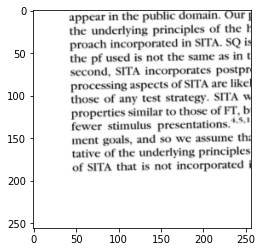

In [19]:
vb_deblur.load_state_dict(torch.load("/notebooks/checkpoints/checkpoint.pth")['model_state_dict'])
vb_deblur.eval()

blur_kernel, blur_img, clean_img = train_data[512]
mu, log_var, simplex, blur_kernel, latent_img = vb_deblur(blur_img.view(1, 3, 256, 256).to("cuda"))

plt.imshow(np.transpose(clean_img.cpu().squeeze(), (1,2,0)))
plt.savefig("clean.png")



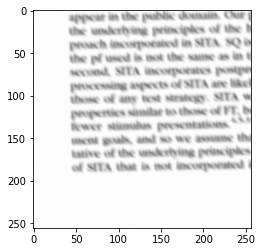

In [20]:
plt.imshow(np.transpose(blur_img.cpu().squeeze(), (1,2,0)))
plt.savefig("blur.png")



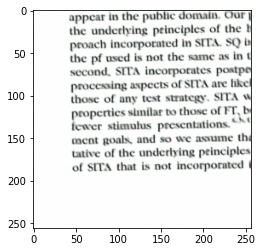

In [21]:
plt.imshow(np.transpose(latent_img.cpu().squeeze(), (1,2,0)))
plt.savefig("gen.png")

### some function to test theory

In [ ]:
# %matplotlib inline

# img = train_data[0][-1]*255

# blur = train_data[0][1]

# var = torch.ones_like(img)*2


# img_dist = torch.distributions.normal.Normal(img, var)
# latent_img = img_dist.sample() 



# blur_gauss = torchvision.transforms.GaussianBlur(15, sigma=(1.5, 1.5))
# latent_img2 = blur_gauss(img)

# print(blur_gauss)

# # img_dist = torch.distributions.multivariate_normal.MultivariateNormal(img.view(-1, 3), var.view(-1,3))
# # multi_latent_img = img_dist.rsample().view(3, 256, 256)

# plt.plot()
# plt.imshow(np.transpose(np.clip(img.to(torch.uint8), 0, 255), (1,2, 0)))

# plt.plot()
# plt.imshow(np.transpose(np.clip(blur, 0, 1), (1,2, 0)))

# plt.plot()
# plt.imshow(np.transpose(np.clip(latent_img, 0, 255).to(torch.uint8), (1,2, 0)))

In [ ]:
# kernel = train_data[0][0]
# kernel = kernel+1e-5

# blur_dist = torch.distributions.dirichlet.Dirichlet(kernel.view(1, -1))
# blur_kernel = blur_dist.sample().view(17,17)
# plt.plot()
# plt.imshow(blur_kernel)

# def filterGauss(latent_img, blur_kernel):
#     c, h, w = latent_img.size()
#     k, k = blur_kernel.size()
#     blur_kernel = blur_kernel.view(1, 1, k, k)
#     channels = []
#     for i in range(c):
#         blur_channel = latent_img[i].view(1,1,h,w)
#         blur_result = torch.nn.functional.conv2d(blur_channel, blur_kernel, stride=[1,1])
#         channels.append(blur_result)
#     return torch.vstack(channels).squeeze()

# blur_result = filterGauss(latent_img, blur_kernel)

# plt.imshow(np.transpose(np.clip(blur_result, 0, 255).to(torch.uint8), (1,2,0)))